&lt;matplotlib.image.AxesImage at 0x7f3045078ac0&gt;

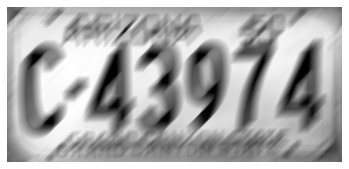

In [58]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

from numpy import unravel_index
from scipy.signal import convolve2d as conv
from skimage.feature import canny
from skimage.transform import hough_line
from skimage import restoration, data, color

# Research on the blind restoration algorithm of motion-blurred image

img = color.rgb2gray(cv.imread('MotionBlur_LicensePlate.png'))
# img = cv.imread('MotionBlur_LicensePlate.png', 0)
plt.axis('off')
plt.imshow(img, cmap='gray')


&lt;matplotlib.image.AxesImage at 0x7f3057ab9be0&gt;

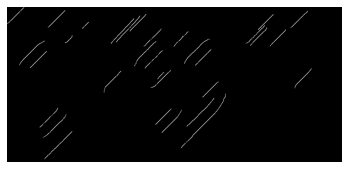

In [45]:
# Detect edges
edges = canny(img, low_threshold=0.2, high_threshold=0.4)
plt.axis('off')
plt.imshow(edges, cmap='gray')


Motion angle : 44.87465181058494


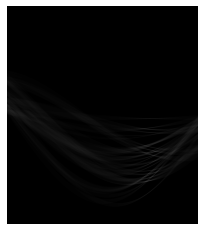

In [63]:
# Estimate motion angle using Hough TF
theta = np.linspace(-np.pi / 2, np.pi / 2, 360)
accumulator, angles, d = hough_line(edges, theta)
# Find angle of dominant dominant line
_, dominant_theta_idx = unravel_index(accumulator.argmax(), accumulator.shape)
motion_angle = np.rad2deg(angles[dominant_theta_idx])
plt.axis('off')
plt.imshow(accumulator, cmap='gray', aspect=1/5)
print(f'Motion angle : {motion_angle}')

In [82]:
def gen_psf_kernel(angle, length, kernel_size):
    psf_kernel = np.zeros((kernel_size,kernel_size))
    